<font size="6">Трансформеры</font>

Порождение выходной последовательности по входной находит применение во многих областях машинного обучения: от обработки естественного языка до генерации описаний объектов на фотографиях.

До недавнего времени наиболее эффективные seq2seq-модели основывались на сложных рекуррентных или сверточных нейронных сетях, беря за основу подход encoder-decoder и механизм внимания. В 2017 году в статье [«Attention Is All You Need» 🎓[arxiv]](https://arxiv.org/abs/1706.03762) была предложена новая архитектура, основанная исключительно на механизмах внимания, названная
Transformer.

# Классический seq2seq

В простейшем варианте модель seq2seq представляет собой две последовательно соединенные рекуррентные сети: **Encoder** и **Decoder**. Encoder принимает на вход последовательность векторных представлений токенов и генерирует **hidden state**, который подается на вход Decoder’а. Decoder, в свою очередь, служит для построения целевой последовательности по внутреннему состоянию.

На примере задачи перевода: на вход кодировщику подается текст на исходном языке. Тогда hidden state можно интерпретировать как смысл этого текста, по которому затем декодировщик восстанавливает текст на целевом языке.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/seq_to_seq_with_rnn.png" width="800">

In [ ]:
# layer norm нормирует по фичам

Было бы здорово так кодировать данные, чтобы сжатые представления на английском языке были близки к сжатым представлениями на русском.

А ещё хорошо бы добиться того, чтобы сжатые представления перестали быть равнозначными. Чтобы учитывался контекст, окружающие слова. Так, для слова "мы" гораздо важнее "we", нежели "bread".

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/attention_vector.png" width="700"></center>

Кроме того, вектор фиксированного размера $h_N$ — бутылочное горлышко сети.

**Идея:** поставить нейросеть поверх $h_1 ... h_4$, чтобы вектор в декодер шёл как взвешенная комбинация векторов.

# Attention

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/seq2seq_encoder_decoder_with_attention.png" width="600"></center>

<center><em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf">К.В. Воронцов, Машинное обучение: Обработка последовательностей и модели внимания</a></em></center>

Концепция **attention** состоит в предположении, что между токенами существуют некоторые взаимосвязи. При таком подходе кодировщик передает в декодировщик не одно состояние, кодирующее всю последовательность целиком, а взвешенный набор состояний всех токенов.

## RNN + Attention

В прошлой лекции мы работали с RNN без внимания. Теперь посмотрим, как это будет со слоем Attention.

Материал на основе [официальной документации PyTorch [doc]](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

### Подготовка данных

Нам понадобится уникальный индекс для каждого слова, чтобы позже использовать его в качестве входных данных и таргетов. Сделаем вспомогательный класс Lang из словарей **слово → индекс** (`word2index`) **и индекс → слово** (`index2word`), а также счетчик каждого слова `word2count`, который будет использоваться для замены редких слов позже.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Все файлы представлены в формате Unicode, поэтому для упрощения мы преобразуем символы Unicode в ASCII, сделаем все строчными и уберём большую часть знаков препинания.

In [ ]:
import re
import unicodedata


def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def normalizeStringRu(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-яА-Я!?]+", r" ", s)
    return s.strip()

Делим файл на строки, а строки — на пары.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/eng_rus_vocab.txt

In [ ]:
from io import open


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = (
        open("%s_%s_vocab.txt" % (lang1, lang2), encoding="utf-8").read().strip().split("\n")
    )

    # Split every line into pairs and normalize
    pairs = [l.split("\t")[:2] for l in lines]
    eng = [normalizeString(s[0]) for s in pairs]
    rus = [normalizeStringRu(s[1]) for s in pairs]
    pairs = list(zip(rus, eng))


    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Для скорости сократим датасет до предложений не длинее 10 слов и отфильтруем апострофы.

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ",
    "i m ",
    "he is",
    "he s ",
    "she is",
    "she s ",
    "you are",
    "you re ",
    "we are",
    "we re ",
    "they are",
    "they re ",
)


def filterPair(p):
    return (
        len(p[0].split(" ")) < MAX_LENGTH
        and len(p[1].split(" ")) < MAX_LENGTH
        and p[1].startswith(eng_prefixes)
    )


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
import random


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng", "rus", False)
print(random.choice(pairs))

Reading lines...
Read 479223 sentence pairs
Trimmed to 29734 sentence pairs
Counting words...
Counted words:
eng 10387
rus 4315
('я очень болен', 'i m really sick')


### Кодировщик-декодировщик

In [ ]:
import torch.nn as nn


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

На каждом этапе декодирования декодеру предоставляется входной токен и скрытое состояние. Начальный входной токен — токен начала строки <SOS>, первое скрытое состояние — вектор контекста (последнее скрытое состояние кодировщика).

In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return (
            decoder_outputs,
            decoder_hidden,
            None,
        )  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Слой Attention

Сначала мы вычисляем **набор весов Attention**. Они будут умножены на выходные векторы энкодера для создания взвешенной комбинации. Результат должен содержать информацию об этой конкретной части входной последовательности и помогать декодеру выбирать правильные выходные слова.

Вычисление весов Attention выполняется с помощью линейного слоя. В данных присутствуют предложения всех размеров, и для фактического создания и обучения этого слоя нужно выбрать максимальную длину предложения. В предложениях максимальной длины будут использоваться все веса внимания, в то время как в более коротких предложениях будут использоваться только первые несколько.

Механизм **аддитивного внимания** реализован в:

[[arxiv] 🎓 Neural Machine Translation by Jointly Learning to Align and Translate (Bandanau et al., 2016)](https://arxiv.org/abs/1409.0473)

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{U}h + \color{red}{V}h')$ — аддитивное внимание с $\color{red}{w, U, V}$.

В оригинальной статье вектора $h$ и $h'$ конкатенируются, т.е. операция выше представляется как:

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{\Omega}[h;h'])$


In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Подготовка к обучению

**Подготовка данных**

Для обучения для каждой пары нам понадобится входной тензор (индексы слов во входном предложении) и целевой тензор (индексы слов в целевом предложении). При создании этих векторов мы добавим токен EOS к обеим последовательностям.

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData("eng", "rus", False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, : len(inp_ids)] = inp_ids
        target_ids[idx, : len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(
        torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device)
    )

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler, batch_size=batch_size
    )
    return input_lang, output_lang, train_dataloader

**Обучение модели**

Для обучения мы пропускаем предложение через кодировщик и отслеживаем каждый выход и последнее скрытое состояние. Затем декодер получает токен <SOS> в качестве первого входа и последнее скрытое состояние кодировщика в качестве первого скрытого состояния.

In [ ]:
def train_epoch(
    dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion
):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

**Процесс обучения**:

* Запустить таймер
* Инициализировать оптимизаторы и loss
* Создать набор обучающих пар

In [ ]:
from torch import optim


def train(
    train_dataloader,
    encoder,
    decoder,
    n_epochs,
    learning_rate=0.001,
    print_every=100,
    plot_every=100,
):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(
            train_dataloader,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
        )
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(
                "%s (%d %d%%) %.4f"
                % (
                    timeSince(start, epoch / n_epochs),
                    epoch,
                    epoch / n_epochs * 100,
                    print_loss_avg,
                )
            )

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Функция для построения графиков.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.switch_backend("agg")


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

**Тестирование**

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(
            encoder_outputs, encoder_hidden
        )

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Мы можем оценить случайные предложения из обучающего набора:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print("RUS", pair[0])
        print("ENG", pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = " ".join(output_words)
        print("DNN", output_sentence)
        print("")

### Обучение и тестирование

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 40, print_every=5, plot_every=5)

Reading lines...
Read 479223 sentence pairs
Trimmed to 29734 sentence pairs
Counting words...
Counted words:
eng 10387
rus 4315
1m 37s (- 11m 25s) (5 12%) 1.2790
3m 15s (- 9m 46s) (10 25%) 0.5119
4m 51s (- 8m 6s) (15 37%) 0.2892
6m 29s (- 6m 29s) (20 50%) 0.1910
8m 5s (- 4m 51s) (25 62%) 0.1428
9m 43s (- 3m 14s) (30 75%) 0.1157
11m 21s (- 1m 37s) (35 87%) 0.0988
13m 0s (- 0m 0s) (40 100%) 0.0879


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

RUS я бесстрашная
ENG i m fearless
DNN i m fearless <EOS>

RUS у нас должно быть много точек соприкосновения
ENG i m sure we have a lot in common
DNN i m sure we have a lot in common <EOS>

RUS он беден
ENG he is poor
DNN they re poor <EOS>

RUS я рад что я тебя нашел
ENG i m glad to have found you
DNN i m glad to have found you <EOS>

RUS ты сама себя обманываешь
ENG you re deceiving yourself
DNN you re lying to blame <EOS>

RUS я не такая высокая как вы
ENG i m not as tall as you
DNN you re not as tall as you <EOS>

RUS я не собираюсь к тому
ENG i m not going to tom s
DNN tom s not going to tom <EOS>

RUS мы не голодны
ENG we re not hungry
DNN they are hungry <EOS>

RUS боюсь с томом что то не так
ENG i m afraid something is wrong with tom
DNN i m afraid something is wrong with tom <EOS>

RUS я делаю все что могу
ENG i m doing everything i can
DNN i m doing everything i can do <EOS>



### Визуализация Attention

input = я достаточно умен чтобы этого не делать
output = i m smart enough not to do that <EOS>


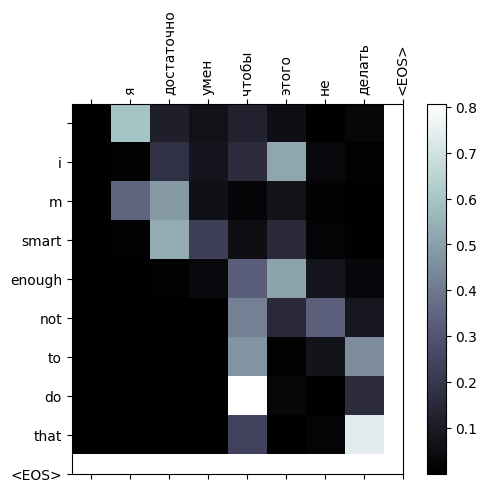

In [ ]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap="bone")
    fig.colorbar(cax)

    # Set up axes
    # prepare number of positions on the axes
    x_ticks = []
    y_ticks = []
    for i in range(0, len(input_sentence.split(" ")) + 2):
        x_ticks.append(i)
    for i in range(0, len(output_words) + 1):
        y_ticks.append(i)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([""] + input_sentence.split(" ") + ["<EOS>"], rotation=90)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([""] + output_words)

    # # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    #plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence, input_lang, output_lang
    )
    print("input =", input_sentence)
    print("output =", " ".join(output_words))
    showAttention(input_sentence, output_words, attentions[0, : len(output_words), :])


#evaluateAndShowAttention("задача состоит в том, чтобы учиться")
evaluateAndShowAttention("я достаточно умен чтобы этого не делать")

## Вычислительная сложность

Attention решает проблему "забывания" при работе с последовательностями. Но цена этого решения — квадратичное возрастание вычислительной сложности с ростом длины последовательности.

Вычислительная сложность **одного слоя RNN** составляет **$O(bn d^2)$**, где $b$ — размер батча, $n$ — длина последовательности и $d$ — размерность эмбеддингов. Часть $d^2$ обусловлена матричным перемножением внутри блока RNN.

Вычислительная сложность **одного слоя attention** в простейшей реализации составляет $O(bn^2 d)$, то есть растет квадратично при росте длины последовательности $n$. Это объясняется тем, что длина выходной последовательности приблизительно равна длине входной последовательности $n$, и необходимо для каждого выходного токена рассчитать коэффициенты attention со всеми входными токенами. Сложность расчета одного коэффициента в простейшем случае составляет $O(d)$.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/transformer_table.png" width="700"></center>

<center><em>Вычислительная сложность одного слоя, количество последовательных операций (которые нельзя распараллелить), максимальня длина пути сигнала в сети от выхода к выходу</em></center>

<center><em>Source: <a href="https://brunomaga.github.io/AI-Supercomputing-2"> AI Supercomputing (part 2): Encoder-Decoder, Transformers, BERT, Sharding, and model compression</a></em></center>

**Ни рекуррентные сети, ни attention не могут эффективно работать с очень длинными последовательностями.** RNN/LSTM "забывают" начало последовательности, а attention просто не может выполнить расчет за разумное время.

## Разновидности функций сходства


$\large a(h, h') = h^Th'$ — скалярное произведение (векторы близких слов практически параллельны);

$\large a(h, h') = \mu * exp(h^Th')$ — возможны степенные операции, добавление долмножения на константу;

$\large a(h, h') = h^T\color{red}{W}h'$ — c матрицей обучаемых параметров $\color{red}{W}$;

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{U}h + \color{red}{V}h')$ — аддитивное внимание с $\color{red}{w, U, V}$.



Вводя внимание, мы говорили о некоторой **функции сходства** между **текущим** скрытым состоянием декодировщика $h'$ и **всеми** скрытыми состояниями кодировщика $h$. Обобщением механизма внимания является введение  **обучаемых параметров**.

Какие вообще бывают функции сходства?


1.   Первое, что приходит голову — просто считать скалярное произведение $h$ и $h'$.
2.   Также можно использовать степенную функцию или умножение на константу.

Первые два способа возможны, только если потребовать, чтобы $h$ и $h'$ имели одинаковую размерность.

3.   Можно вводить матрицу обучаемых параметров $W$.
4.   Можно вводить небольшую двухслойную нейронную сеть с несколькими весовыми матрицами. Такое введение функции сходства называется аддитивным вниманием.



### Key, Query, Value


Часто используемым подходом является введение трех типов векторов, которые называют **Query**, **Key** и **Value**.

$q$ — вектор-запрос, для которого хотим вычислить контекст [декодировщик]

$K = (k_1,..., k_n)$ — векторы-ключи, сравниваемые с запросом [кодировщик]

$V = (v_1,..., v_n)$ — векторы-значения, образующие контекст [кодировщик]









**Рассмотрим задачу перевода**

Я видел мохнатого котю на лежанке. ------> I saw furry **cat** on the bed.

* query: cat

* K: ['Я', 'видел', 'мохнантого', 'котю', 'на', 'лежанке', '.'] -> ['0', '0', '0.6', '1', '0', '0', '0']

* V: ['Я', 'видел', 'мохнантого', 'котю', 'на', 'лежанке', '.'] -> ['Я', 'видел', <font color='coral'>'мохнантого'</font>, <font color='darkred'>'котю'</font>, 'на', 'мате', '.']

**Иными словами**:


$\large c = \text{Attn}(q, K, V) =  \Sigma_i v_{i} \text{SoftMax}(a(k_i, q)),$

где $a(k_i,q)$ — оценка сходства ключа $k_i$ запросу $q$.

$\large \text{Attn}(Q, K, V) =  \text{SoftMax}(\dfrac{QK^{T}}{\sqrt{d_K}})V$ — на практике Attention вычисляется для набора запросов, сформированных в матрицу $Q$. Таким образом мы переходим к матричной форме записи.


**Линейные преобразования векторов** **Query**, **Key** и **Value**.

Для каждого типа вектора вводится свое линейное преобразование, которое из исходного вектора делает вектор в каком-то другом пространстве. Все три они обычно приводятся к одной и той же размерности, обозначенной $d$.

<div align="center">
    <table >
     <tr>
       <td>
       
$$\large a(h_i, h^\prime_{t-1}) = (\color{red}{W_k}h_i)^T(\color{red}{W_q}h^\prime_{t-1}) / \sqrt d$$

$$\large \alpha_{ti} = \text{SoftMax} \space a(h_i, h^\prime_{t-1})$$

$$\large c_t = \Sigma_i \alpha_{ti} \color{red}{W_v} h_i$$

$$ \sum_{i=1}^{N}a_{ti} = 1,$$

$$  0\leqslant a_{ti} \leqslant 1.$$

$ \large \color{red}{W_q}_{d \times dim(h^\prime)}, \color{red}{W_k}_{d \times dim(h)}, \color{red}{W_v}_{d \times dim(h)}$ — матрицы

весов Query, Key, Value, линейные слои в пространстве

 размерности $\large d$).


Возможно упрощение модели: $\large \color{red}{W_k} \equiv \color{red}{W_v}$
       
</td>
<td>
<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/query_key_value.png" width="250">

<center><em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf">Обработка последовательностей: модели внимания и трансформеры</a></em></center>
        </td>
     </tr>
    </table>
    </div>

# Архитектура сети Transformer

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/transformer_architecture.png" width="450"></center>

<center><em>Архитектура трансформера</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.03762.pdf"> Attention Is All You Need</a></em></center>

Архитектура, построенная целиком на механизме внимания, без свёрток и рекуррентных блоков, изначально была создана для задачи машинного перевода с применением распараллеливания на GPU.

# Кодировщик

## Алгоритм

<div align="center">
    <table >
     <tr>
       <td>

Порядок вычислений трансформера-кодировщика:

1. Добавляются позиционные векторы $p_i$:

$\qquad \large h_i = x_i + p_i;$

$\qquad \large H = (h_1, \dots, h_n).$

$\qquad$ Размерность: $dim \ x_i, \ p_i, \ h_i = 512, \ dim \ H = 512 \times n$

2. Многомерное самовнимание:

$\qquad \large h^j_i = Attn(\color{red}{W^j_q}h_i, \color{red}{W^j_k}H, \color{red}{W^j_v}H).$

$\qquad$ Размерность: $j = 1, \dots, J=8, \ dim \ h^j_i = 64, \ dim \ W^j_q, \ W^j_k, \ W^j_k = 64 \times 512 $

3. Конкатенация:

$\qquad \large h'_i =  MH_j (h^j_i) \equiv [h^1_i, \dots, h^J_i].$

$\qquad$ Размерность: $dim \ h'_i = 512$

4. Сквозная связка + нормировка уровня:

$\qquad \large h''_i =  LN(h'_i + h_i; \color{red}{\mu_1, \sigma_1}).$

$\qquad$ Размерность: $dim \ h''_i, \ \mu_1, \ \sigma_1 = 512$

5. Полносвязная 2-хслойная сеть FFN:

$\qquad \large h'''_i = \color{red}{W_2}ReLU(\color{red}{W_1}h''_i + \color{red}{b_1}) + \color{red}{b_2}.$

$\qquad$ Размерность: $dim \ W_1 = 2048\times512, \ dim \ W_2 = 512\times2048$

6. Сквозная связь + нормировка уровня:

$\qquad \large z_i = LN(h'''_i + h''_i; \color{red}{\mu_2, \sigma_2}).$

$\qquad$ Размерность: $dim \ z_i, \ \mu_2, \ \sigma_2 = 512$
       </td>
        <td>
<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/transformer_encoder.png" width="200"></center>

<em>Архитектура трансформера-кодировщика</em>

<em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf"> К.В. Воронцов, Машинное обучение: Обработка

последовательностей и модели внимания</a></em>
        </td>
     </tr>
    </table>
    </div>

В качестве слоя нормировки используется LayerNorm, которая рассчитывает статистики не по объектам в батче, а по каждому признаку каждого объекта независимо.



* Layer Normalization

$\qquad  \large x_i, \ \color{red}{\mu}, \ \color{red}{\sigma} \in \mathbb{R};$

$\qquad  \large \displaystyle LN_s(x; \color{red}{\mu}, \ \color{red}{\sigma}) = \color{red}{\sigma_s} {{x_s - \overline x} \over \sigma_x} + \color{red}{\mu_s}, \ s = 1, \dots, d;$

$\qquad \displaystyle \overline x = {1 \over d} \sum\limits_{s}x_s$ и $\displaystyle \sigma^2_x = {1 \over d} \sum\limits_{s}(x_s - \overline x)^2$ — среднее и дисперсия $x$.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/power_norm.png" width="400"></center>

<center><em>Source: <a href="https://proceedings.mlr.press/v119/shen20e/shen20e.pdf">PowerNorm: Rethinking Batch Normalization in Transformers</a></em></center>

Причина: в задачах NLP длины предложений разнятся, поэтому на какой $d$ делить в формуле выше — вопрос открытый. Кроме того, от батча к батчу константа нормировки будет отличаться и статистики будут нестабильны во время обучения.

##Self-Attention

Внутри кодировщика применяются слои "Self-Attention", внутреннего внимания, или же самовнимания.

Каждое слово идет по своей собственной траектории в энкодере. И, хотя существуют зависимости между этими траекториями в слое внутреннего внимания, в слое сети прямого распространения таких зависимостей нет, что позволяет различным траекториям выполняться параллельно во время прохождения через этот слой.

**Self-Attention** – ключевая часть модели, позволяющая находить связи между словами в предложении (или объектами в слое).


<div align="center">
    <table >
     <tr>
        <td><b style="font-size:60px">
        
Attention</b>
        </td>
        <td><b style="font-size:60px">
        
Self-attention</b></td>
     </tr>
     <tr>
       <td>

**Откуда:** из одного текущего состояния декодера

**Куда:** во все состояния кодировщика
       </td>
      <td>

**Откуда:** из каждого состояния в слое

**Куда:** во все состояния в том же слое
        </td>
     </tr>
    </table>
    </div>



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/encoder_self_attention.gif" width="700"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita NLP Course</a></em></center>

[[colab] 🥨 Интерактивный блокнот для визуализации Self-Attention](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=twSVFOM9SopW)

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/qkv_explained.png" width="800"></center>

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/qkv_attention_formula.png" width="400"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita NLP Course</a></em></center>

## Multihead Attention

**Идея:** $J$ разных моделей внимания совместно обучаются выделять различные аспекты входной информации (например, части речи, синтаксим, фразеологизмы):

$\large c_j = \text{Attn}(\color{red}{W^j_q}q, \color{red}{W^j_k}H,\color{red}{W^j_v}H, \ j = 1, \dots, j)$

**Варианты** агрегирования выходного вектор:

$\large \displaystyle c = {1 \over j} \sum\limits^J_{j=1}c^j$ — усреднение;

$\large \displaystyle c = [c^1 \dots c^J]$ — конкатенация;

$\large \displaystyle c = [c^1 \dots c^J]\color{red}{W}$ — возвращение к нужной размерности.

Давайте посмотрим на то, к каким словам предложения gave может иметь отношение. В общем случае глагол может иметь связку со многими частями предложения. Как, например, с подлежащим, так и с причастиями.

В идеале, нам бы хотелось обратить внимание функции (attention) на все эти взаимосвязи. Для этого нам просто надо поставить несколько attention слоев параллельно. Тогда каждый из них будет учить что-нибудь свое по аналогии со сверточными слоями.

* Чтобы осуществить задуманное, вместо одного набора query будем использовать несколько независимых наборов.

* Причем каждый набор будет считаться уникальной матрицей.

* Аналогично сделаем для keys и values. Количество таких наборов внутри keys, queries, values должно быть **одинаковым**.

* Обозначим это число как $J$, далее производим аналогичные манипуляции, при этом введем в параллель h таких функций attention.

* На последнем шаге мы их соединяем (конкатенируем).

* При этом можно заметить, что при таком подходе на каждом шаге размерность токена будет увеличиваться (если, например, в качестве и key, и value, и query мы подаем одно и тоже предсталение токена). Если хотим сохранять управление размерностью токена, то придется получать по меньшей мере value путем домножения на матрицу, размерность которой по второй оси меньше — **выполнять проекцию наших токенов в пространство меньшей размерности**.

* В частности, можно подобрать размерность этого пространства таким образом, чтобы при конкатенации размерность полученного токена равнялась исходной.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/multihead_self_attention_layer.png" width="700">

**Positional encoding**

Единственный возможный минус — нейросеть не учитывает порядок слов в предложении при составлении embedding. Это может нам мешать. Например, если в предложении два it, то они часто относятся к разным словам. Поэтому хотелось бы уметь учитывать информацию о позиции. Для этого к $X$ при составлении $Q$ добавляется информация о позиции.

Делается это хитрым образом: мы добавляем к каждому значению исходного вектора токенов некую комбинацию $sin$ и $cos$ с разными параметрами. **Значения суммируются, а не конкатенируются.**

Вектор $PE$, который мы будем добавлять к $X$, будет определяться по следующей формуле:

$$\large p_{\text{pos}, 2i} = \sin \left({\dfrac {\text{pos}} {10000^{2i/d}}}\right)$$

$$\large p_{\text{pos}, 2i+1} = \cos \left({\dfrac {\text{pos}} {10000^{2i/d}}}\right)$$

$\text{pos}$ — это позиция токена

$d$ — количество размерностей токена

$i$ — $i$-тая размерность токена

In [ ]:
import math
import torch


class PositionalEncoding(torch.nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].detach()
        return x

In [ ]:
pe = PositionalEncoding(20)
y = pe(
    torch.zeros(1, 100, 20)
)  # sequence of shape 100, every token of sequence has shape 20

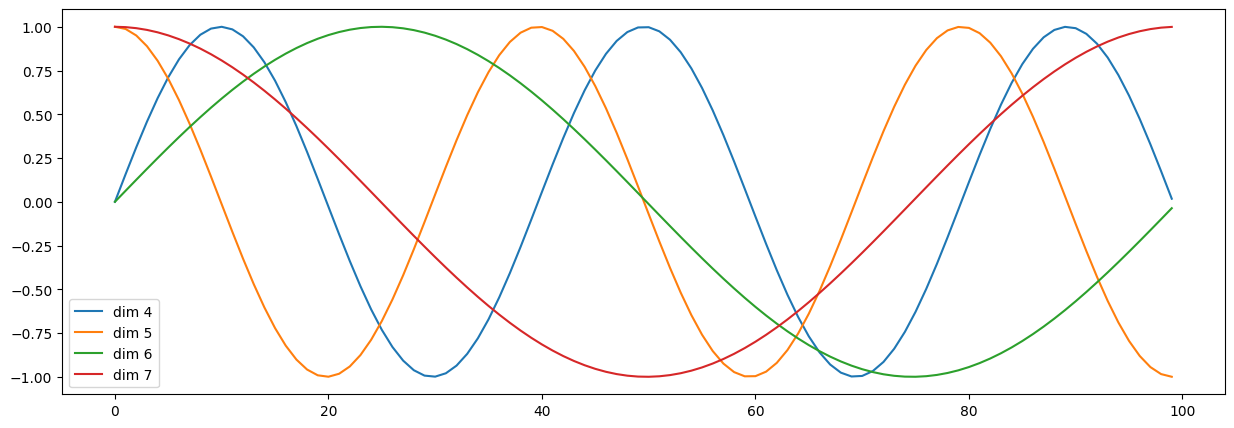

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
plt.show()

В результате каждая позиция кодируется уникальным представлением. При этом представление позволяет легко находить слова на заданном расстоянии от исходного (у них будет одинаково значение сигнала по какой-то оси).

Это помогает трансформеру достаточно уникальным образом определять каждую позицию и понимать относительное расстояние между разными токенами.

**Почему не используется одно число, например значение индекса?**

Для длинных последовательностей индексы могут сильно увеличиваться по величине. Если вы нормализуете значение индекса так, чтобы оно лежало между $0$ и $1$, это может создать проблемы для последовательностей переменной длины, поскольку они будут нормализованы по-разному.

Поэтому используется кодирование позиции в виде вектора, который прибавляется к эмбеддингу токена. Эти позиционные эмбеддинги можно как зафиксировать заранее (так делается в оригинальном трансформере, см. пример на картинке), так и обучать, как в случае GPT.

##BERT

### Постановка задачи

Модель решает две задачи.

1. MLM (masked language model), предсказание маскированных токенов. Для этой задачи появляется специальный токен **[MASK]**.

2. NSP (Next Sentence Prediction), предсказание, следует ли текущее предложение за предыдущим. Для этого появляется специальные токены [CLS] (для классификации) и [SEP] (для разделения предложений, которые подаются парой и следуют друг за другом).


Сеть училась на обоих задачах одновременно.

Для предсказания замаскированного токена используется дополнительный слой - классификатор. Аналогично, для решения задачи NSP выход токена [CLS] отправляется на полносвязную сеть.






<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/bert.png" width="600"></center>

Благодаря процедуре маскирования, BERT-подобные модели могут обучаться без учителя на огромных корпусах текстов, тем самым изучае стуктуру языка.

Далее, предобученные BERT-подобные модели можно использовать так:

* использовать их выходы как признаки для других моделей;

* дообучать под наши задачи.

Однако, для начала посмотрим на инференс модели.

### Примеры применения

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
print('BERT output shape:', embed_bert_cls('Привет мир', model, tokenizer).shape)

BERT output shape: (312,)


Или же через альтернативный запуск

In [ ]:
!pip install sentence_transformers --progress-bar off

Теперь подадим 3 предожения и убедимся, что их вектор-представления совпадают по размеру.

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('cointegrated/rubert-tiny2')
sentences = ["привет мир", "hello world", "предложение подлиннее для проверки"]
embeddings = model.encode(sentences)
print('BERT output shape:', embeddings.shape)

BERT output shape: (3, 312)


Самый простой способ использовать готовые модели - импортировать [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines).

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline(task = "sentiment-analysis", model = 'blanchefort/rubert-base-cased-sentiment')
type(classifier)

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
classifier("Отличное морозное утро!")

[{'label': 'POSITIVE', 'score': 0.9534334540367126}]

In [ ]:
classifier("Отличное морозное утро, холод собачий!")

[{'label': 'NEGATIVE', 'score': 0.7517329454421997}]

А теперь давайте возьмём задачку посложнее. И классифицируем звук.

Режим работы модели - "zero-short learning", т.е. модель не видела во время обучения подобные данные.

In [ ]:
!pip install datasets --progress-bar off
from datasets import load_dataset

In [ ]:
dataset = load_dataset("ashraq/esc50")
audio = next(iter(dataset["train"]["audio"]))["array"]

In [ ]:
from IPython.display import Audio, display

display(Audio(audio, rate = 16000, autoplay=True))

In [ ]:
classifier = pipeline(task="zero-shot-audio-classification", model="laion/clap-htsat-unfused")
classifier(audio, candidate_labels=["Sound of a dog", "Sound of a bird"])

[{'score': 0.9823783040046692, 'label': 'Sound of a dog'},
 {'score': 0.01762172393500805, 'label': 'Sound of a bird'}]

**Предобученные модели для разных задач**

В [репозитории HuggingFace](https://huggingface.co/docs/transformers/model_doc/bert) уже имеется множество моделей, предобученных для различных задач:

* Text Classification
* Fill-Mask
* Question Answering
* ...

Для каждой задачи есть шаблон модели, в которую нужно подать чекпоинт (название).

Например, для решения задачи классификации текстов на 6 классов:

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-large')
model = BertForSequenceClassification.from_pretrained('sberbank-ai/ruBert-large', num_labels=6).to("cuda")

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Примеры с обучением

Базовый вариант работать с векторами из моделей BERT - работать с ними, как с вектор-представлениями наших данных.

И подавать эти вектора на уже известные нам модели.

Загрузим новостные сводки BBC и научимся их классифицировать.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/bbc.zip
!unzip -q bbc.zip

--2023-12-10 16:45:47--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/bbc.zip
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2936516 (2.8M) [application/zip]
Saving to: ‘bbc.zip’

bbc.zip             100%[===================>]   2.80M  4.62MB/s    in 0.6s    

2023-12-10 16:45:48 (4.62 MB/s) - ‘bbc.zip’ saved [2936516/2936516]



In [ ]:
import numpy as np
import re, os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Соберём данные в таблицу `pandas`.

In [ ]:
directory = []
file = []
title = []
text = []
label = []
datapath = './bbc/'
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'category'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)),
               columns =['directory', 'file', 'title', 'text', 'category'])

df = fulldf.filter(['text','category'], axis=1)
df.head()

,text,category
0,Jade Johnson is undecided about whether to c...,sport
1,Former captain Keith Wood believes Ireland c...,sport
2,Newcastle manager Graeme Souness is closing ...,sport
3,"Sania Mirza, the first Indian woman to reach...",sport
4,Arsenal boss Arsene Wenger says he has no pl...,sport


Проверим, какие у нас метки.

In [ ]:
for label in np.unique(df['category']):
    print(label)

business
entertainment
politics
sport
tech


Переведём эти текстовые классы в числовые метки.

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['label'] = LE.fit_transform(df['category'])
df.head()

,text,category,label
0,Jade Johnson is undecided about whether to c...,sport,3
1,Former captain Keith Wood believes Ireland c...,sport,3
2,Newcastle manager Graeme Souness is closing ...,sport,3
3,"Sania Mirza, the first Indian woman to reach...",sport,3
4,Arsenal boss Arsene Wenger says he has no pl...,sport,3


Отметьте, что мы используем параметр `model_max_length`. Это необходимо как потому, что на длинных текстах получаются вектора большей длины, так и потому, что очень хочется не выйти за границы доступной памяти в Google Colab.

Используем небольшую модель.

In [ ]:
!pip install transformers --progress-bar off

import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", model_max_length=312)
model = AutoModel.from_pretrained("prajjwal1/bert-tiny").to(device)

Посмотрим на количество текстов. Относительно много.

In [ ]:
print(len(df))

2225


Оставим случайные 50% датасета для экономии ресурсов.

In [ ]:
df = df.sample(frac=0.5)

Разделим на обучение и валидацию.

In [ ]:
df_train = df.sample(frac=0.8)
df_val = df.drop(df_train.index)

In [ ]:
tokenized_train = tokenizer(df_train["text"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(df_val["text"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())

#move on device (GPU)
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


<ipython-input-23-9cf6573ebaf7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
<ipython-input-23-9cf6573ebaf7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [ ]:
with torch.no_grad():
  hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
  hidden_val = model(**tokenized_val)

#get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
x_train = cls_train.to("cpu")
y_train = df_train["label"]

x_val = cls_val.to("cpu")
y_val = df_val["label"]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_val_pred = rf.predict(x_val)

torch.Size([356, 128]) (356,) torch.Size([89, 128]) (89,)


0.9325842696629213

In [ ]:
print(classification_report(y_val_pred,y_val.values))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.87      0.93      0.90        14
           2       0.92      1.00      0.96        12
           3       0.96      1.00      0.98        24
           4       0.94      0.94      0.94        17

    accuracy                           0.93        89
   macro avg       0.93      0.94      0.93        89
weighted avg       0.93      0.93      0.93        89



Сравним с Dummy-классификатором. Результат говорит о том, что наш хороший результат получился не просто так.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy= "uniform")
dummy.fit(x_train,y_train)
y_val_pred = dummy.predict(x_val)

0.21348314606741572

In [ ]:
print(classification_report(y_val_pred,y_val.values))

              precision    recall  f1-score   support

           0       0.26      0.31      0.29        16
           1       0.40      0.35      0.38        17
           2       0.23      0.12      0.16        24
           3       0.12      0.19      0.15        16
           4       0.24      0.25      0.24        16

    accuracy                           0.24        89
   macro avg       0.25      0.25      0.24        89
weighted avg       0.25      0.24      0.24        89



**А теперь дообучим саму модель BERT**

Здесь мы используем другой датасет и покажем, что в hugging face есть крайне богатая библиотека датасетов.

In [ ]:
!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git datasets evaluate --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from datasets import load_dataset

imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-large')
model = BertForSequenceClassification.from_pretrained('sberbank-ai/ruBert-large').to(device)

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

Предобработка данных

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_imdb["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
})

In [ ]:
tokenized_imdb["train"].shape

(25000, 4)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


В Hugging Face есть свой собстенный интерфейс дообучения моделей.

Объект класса `TrainingArguments` агрегирует параметры, которые затем передаются в объект класса Trainer.

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,#about 15 minutes for 1 epoch
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyboardInterrupt: ignored

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,#about 15 minutes for 1 epoch
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.225000,0.204599,0.919520
2,0.144700,0.234069,0.931760


TrainOutput(global_step=3126, training_loss=0.20551106446230175, metrics={'train_runtime': 3066.6657, 'train_samples_per_second': 16.304, 'train_steps_per_second': 1.019, 'total_flos': 6556904415524352.0, 'train_loss': 0.20551106446230175, 'epoch': 2.0})

## BertScore

**BERTScore**

Одна из самых популярных метрик, [предложенная Zhang et al.](https://arxiv.org/pdf/1904.09675.pdf) в 2019 для оценки качества генерируемого текста. Основана на оценке близости контекстных эмбеддингов, полученных из предобученной нейросетевой модели BERT. Частично **решает проблему синонимов и опечаток** метрик BLEU и ROUGE.

Для расчета BERTScore близость двух предложений – сгенерированного моделью и эталонного – оценивается как сумма косинусных подобий между эмбеддингами слов, составляющих эти предложения.



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/architecture_bertscore.png" width="1000"></center>

<center><em>Source: <a href="https://wiki.math.uwaterloo.ca/statwiki/index.php?title=BERTScore:_Evaluating_Text_Generation_with_BERT">The Illustrated GPT-2 (BERTScore: Evaluating Text Generation with BERT)</a></em></center>

На основе обоих токенов рассчитывается **Recall**, **Precision** и **F1**:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/bertscore_equations.png" width="1000"></center>

<center><em>Source: <a href="https://wiki.math.uwaterloo.ca/statwiki/index.php?title=BERTScore:_Evaluating_Text_Generation_with_BERT">The Illustrated GPT-2 (BERTScore: Evaluating Text Generation with BERT)</a></em></center>

Научимся это делать

In [ ]:
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

!pip install -q evaluate --progress-bar off
!pip install -q bert_score --progress-bar off

Из важных параметров стоит [упомянуть](https://huggingface.co/spaces/evaluate-metric/bertscore) выбор языка и тип модели. По-умолчанию используется `roberta-large`, и, чтобы не загружать 1.4G Гб, мы выставляем более мелкую модель менее чем в 300 Мб.

In [ ]:
from evaluate import load

bertscore = load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en",
    nthreads=-1,
    batch_size=128,
    model_type="distilbert-base-uncased",
)

In [ ]:
results

{'precision': [0.9999998807907104, 0.9999998807907104],
 'recall': [0.9999998807907104, 0.9999998807907104],
 'f1': [0.9999998807907104, 0.9999998807907104],
 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.35.2)'}

Отметим, что результат зависит от того, что мы принимаем за референс. Поэтому мы получаем пару чисел.

# Декодировщик

<div align="center">
    <table >
     <tr>
       <td>
       
Авторегрессионный синтез последовательности:

$\large y_0 = \langle {BOS} \rangle$ — эмбеддинг символа начала.

Для всех $t = 1, 2, \dots$ выполняется следующая последовательность вычислений:

1. Маскирование "данных из будущего":

$\qquad \large h_t = y_{t-1} + p_t;$

$\qquad \large H_t = (h_1, \dots, h_t).$

2. Многомерное самовнимание:

$\qquad \large h'_t = LN \circ MH_j \circ Attn(\color{red}{W^j_q}h_t, \color{red}{W^j_k}H_t, \color{red}{W^j_v}H_t).$

3. Многомерное внимание на кодировку $Z$:

$\qquad \large h''_t = LN \circ MH_j \circ Attn(\color{red}{W^j_q}h'_t, \color{red}{W^j_k}Z, \color{red}{W^j_v}Z).$

4. Двухслойная полносвязная сеть:

$\qquad \large y_t = LN \circ FFN(h''_t).$

5. Линейный предсказывающий слой:

$\qquad \large p(\tilde w | t) SoftMax_{\tilde w}(\color{red}{W_y}y_t + b_y).$

Генерация $\tilde w_t = argmax(p(\tilde w | t))$ продолжается пока $\tilde w_t \neq \langle {EOS} \rangle$.

       
</td>
<td>
<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/transformer_decoder.png" width="350">

<em>Архитектура трансформера-декодировщика</em>

<em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf"> К.В. Воронцов, Машинное обучение:

Обработка последовательностей и модели внимания</a></em>
        </td>
     </tr>
    </table>
    </div>

## GPT

### Постановка задачи

Есть широкий класс задач по пониманию естественного языка (распознавание текста, ответы на вопросы и пр.). Гипотеза состояла в том, чтобы добиться успеха путём генеративной предварительной подготовки языковой модели на разнообразном корпусе неразмеченного текста с последующей дискриминационной тонкой настройкой для каждой конкретной задачи.

Для решения задачи обучения без учителя вводился Masked Self-Attention, о котором ниже.

### Архитектура

При генерации продолжения текста с помощью GPT происходит следующее:

1. Входной текст токенизируется в последовательность чисел (токенов).
2. Список токенов проходит через Embedding layer (линейный слой) и преобразуется в список эмбеддингов.
3. К каждому эмбеддингу прибавляется **positional embedding**.
4. Список эмбеддингов проходит через несколько одинаковых блоков (Transformer Decoder Block).
5. После того, как список эмбеддингов пройдёт через последний блок, эмбеддинг, соответствующий последнему токену, матрично умножается на всё тот же входной, но уже транспонированный Embedding Layer, и после применения SoftMax получается распределение вероятностей следующего токена.
6. Из этого распределения выбирается следующий токен (например, с помощью argmax)
7. Полученный токен добавляется к входному списку токенов, шаги 1-6 повторяются

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/gpt3.gif" width="800"></center>

<center><em>Source: <a href="https://jalammar.github.io/how-gpt3-works-visualizations-animations/">How GPT3 Works — Visualizations and Animations</a></em></center>

### Masked Self-Attention Layer


Допустим,  у нас стоит проблема, что мы не должны видеть часть слов в предложении — например, при генерации текста (по текущим словам предсказать следующее). Например, хотим сгенерировать фразу "robot must obey orders" на основе только первого слова.

Если мы подадим в нейронную сеть во время обучения сразу все предложение, которое хотим генерировать, то у нас в первых словах будет "протекать" информация о предыдущих.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/queries_keys_scores_before_softmax.png" width="800">

В этом случае мы можем просто на соответствующих местах матрицы $E$ поставить минус бесконечности. Тогда в эмбеддингах слов, которые не должны знать о каких-то словах, информации об этих словах не будет.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/scores_before_softmax_apply_attention_mask_masked_scores_before_softmax.png" width="800">

В результате после SoftMax "лишняя" информация не будет использоваться при генерации ответа на query.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/masked_scores_softmax_along_rows_scores.png" width="800">

<em>Source: <a href="https://jalammar.github.io/illustrated-gpt2/">The Illustrated GPT-2 (Visualizing Transformer Language Models)</a></em>

Благодаря этому трюку у нас получается обучать transfomer по-прежнему как простую single-pass нейросеть, а не "скатываться" в RNN, где у нас возникнут проблемы с градиентами и временем работы.

Далее часть текста основана на статье [GPT для чайников: от токенизации до файнтюнинга](https://habr.com/ru/articles/599673/).


### Пример применения

Для работы с GPT будем использовать предобученную модель. Лучший выбор для работы с трансформерами — библиотеки от **Hugging Face**: `transformers`, `tokenizers`, `datasets`.

Hugging Face занимается стандартизацией применения трансформеров, а также хранит наборы весов и датасеты для различных NLP-задач. Воспользуемся русскоязычной моделью ruGPT3 и дообучим её.



Установим библиотеку Transformers:

In [ ]:
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00


Выберем необходимую модель. API для различных моделей одинаковый, для подмены модели достаточно изменить название модели `model_name`.

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from IPython.display import clear_output

transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and initialization of model and tokenizer
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

clear_output()

Например, если мы хотим при помощи языковой модели ответить на вопрос: **«Сколько будет 2+2?»**, то можем подать на вход модели следующий текст:\
`«Вопрос: Сколько будет 2+2? Ответ: … »`\
и естественным продолжением такого текста будет ответ на вопрос, поэтому модель допишет `«4»`

In [ ]:
text = "Вопрос: 'Сколько будет 2+2?'\nОтвет:"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20, pad_token_id=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text)

Вопрос: 'Сколько будет 2+2?'
Ответ: '2+2=4'


Похожим способом можно кратко пересказывать тексты, если в конце дописывать `«TL:DR»`, т.к. модель во время обучения запомнила, что после этих символов идёт краткое содержание. Подбор модификаций текста называется **«Prompt Engineering»**. Такая простая идея позволяет решать практически неограниченное количество задач. Именно поэтому многие считают GPT-3 подобием сильного искусственного интеллекта.

### Токенизация

**Byte Pair Encoding**

Изначально алгоритм компрессии BPE позволяет моделям узнавать как можно больше слов при ограниченном объеме словаря.

1.   Слово = последовательность токенов
2.   Словарь = все токены
3.   Повторять, пока не достигли ограничения на размер словаря:

     Назначаем новым токеном объединение двух существующих токенов, которое
встречается чаще других пар в корпусе (встречаются вместе).

В применении BPE возможны разные варианты. Один из естественных – идём по всем токенам по убыванию частоты, находим соответствующую последовательность символов в корпусе, заменяем на токен.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/subword_tokenization.png" width = "500"></center>

<center><em>Source: <a href="https://alexanderdyakonov.wordpress.com/2019/11/29/токенизация-на-подслова-subword-tokenization/">Токенизация на подслова (Subword Tokenization)</a></em></center>

Этот же способ помогает решить **проблему** **OOV (out of vocabulary)**. В обучающей выборке может не быть слова *Unfriendly*, но поскольку **Unfriendly** = **Un** + **friend** + **ly**, мы можем рассчитывать, что сеть будет правильно обрабатывать / генерировать и слово целиком.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/token_unfriendly.png" width="600"></center>

<center><em>Source: <a href="https://www.thoughtvector.io/blog/subword-tokenization/">Subword Tokenization — Handling Misspellings and Multilingual Data</a></em></center>

Но даже это иногда не самый оптимальный выбор. Чтобы сжать словарь ещё сильнее, для обучения GPT OpenAI использовали **byte-level BPE** токенизацию. Эта модификация BPE работает не с текстом, а напрямую с его байтовым представлением. Использование такого трюка позволило сжать словарь до всего-лишь ~50k токенов при том, что с его помощью всё ещё можно выразить любое слово на любом языке мира (и даже эмодзи).

In [ ]:
try:
    import transformers
except ModuleNotFoundError:
    !pip install -q transformers[torch]

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from IPython.display import clear_output

transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and initialization of model and tokenizer
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(device)

clear_output()

**Пример токенизации**

In [ ]:
text = "Нейронные сети - это очень просто и увлекательно"
tokens = tokenizer.encode(text, add_special_tokens=False)

decoded_tokens = [tokenizer.decode([token]) for token in tokens]

print("Original text:", text)
print("Tokens: ", tokens)
print("Decoded tokens: ", decoded_tokens)

Original text: Нейронные сети - это очень просто и увлекательно
Tokens:  [682, 355, 1368, 448, 5324, 376, 481, 939, 1139, 289, 13904, 1245]
Decoded tokens:  ['Н', 'ей', 'рон', 'ные', ' сети', ' -', ' это', ' очень', ' просто', ' и', ' увлека', 'тельно']


Byte-level токенизатор **не гарантирует**, что для любого токена найдется **соответствующий** символ или слово. Некоторые **токены** **существуют** только **в комбинациях**. Так, представленные токены не декодируются по отдельности.

In [ ]:
print(tokenizer.decode([167]))
print(tokenizer.decode([245]))
print(tokenizer.decode([256]))

print(tokenizer.decode([167, 245, 256]))

�
�
�
撝


## Методы Генерации текста

Языковая модель генерирует распределение вероятностей следующего токена. Однако способы генерации текста могут отличаться. Далее разберём, какие варианты бывают.

Для наглядности применим основные методы для продолжения следующего текста  \
`'Определение: "Нейронная сеть" — это'`

In [ ]:
text = 'Определение: "Нейронная сеть" - это'
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

### Greedy Search

Очевидный вариант — ArgMax-генерация (жадный поиск). Выбирается максимально вероятный токен.

При таком способе мы не получим разнообразного текста на один и тот же запрос, и, что ещё хуже, генерация может застревать в локальных минимумах и выдавать повторяющиеся фрагменты, например `the the the the ...`.

In [ ]:
# ArgMax is defaulf behaviour
out = model.generate(input_ids, do_sample=False, max_length=30, pad_token_id=30)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это компьютерная программа, которая позволяет создавать и анализировать нейронные сети. Нейронные сети


### Beam Search
Несколько более сложный и качественный способ сэмплирования — **beam search**. Каждый раз мы выбираем не один самый вероятный токен, а сразу несколько (`beam-size`), и дальше продолжаем поиск для каждого из выбранных токенов.

Таким образом создаётся **граф** со сгенерированными **вариантами предложений**. Далее выбирается предложение с наибольшей **perplexity** (уверенностью модели в реалистичности текста).

Обычно это приводит к высокой связности (когерентности) текста, но при этом к сухости и скучности текста. Также это не решает полностью проблему с повторениями кусочков текста.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/beam_search.png" width="500"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/599673/">GPT для чайников: от токенизации до файнтюнинга</a></em></center>



In [ ]:
# Generation with beam-search
out = model.generate(
    input_ids, do_sample=False, num_beams=5, max_length=30, pad_token_id=30
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это компьютерная сеть, состоящая из компьютеров, соединенных друг с другом. Нейронная


### Сэмплирование с Температурой

Чтобы добавить тексту непредсказуемости и человечности, можно использовать вероятностное сэмплирование с температурой. Будет использоваться не самый вероятный токен, а случайный, с учётом распределения вероятностей.

Параметр температуры позволяет контролировать степень случайности. При нулевой температуре метод совпадает с жадным сэмплированием, при  большой температуре токены будут выбираться полностью случайно. Обычно хорошо работает температура в диапазоне `0.8–2.0`.

Формула модификации распределения вероятностей очень похожа на формулу распределения Больцмана: чем выше температура системы, тем больше "размазывается" распределение вероятностей её возможных состояний, отсюда слово "температура".

$$p=softmax(log(p)/t)$$

Стоит отметить, что случайная природа генерации будет иногда приводить к полностью некорректным результатам.

In [ ]:
out = model.generate(
    input_ids, do_sample=True, temperature=1.3, max_length=30, pad_token_id=30
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это термин, который позволяет сделать описание всех физических состояний объектов, их структур или физических процессов и состояний


### Сэмплирование с Ограничением Маловероятных Токенов (Nucleus sampling)

Можно ввести запрет на семплирование наименее вероятных токенов:

* `top-k` зануляет все вероятности, кроме $k$ наибольших;

* `top-p` оставляет минимальный набор токенов, причём сумма их вероятностей будет не больше $p$.

`top-p` ограничение называют **Nucleus Sampling**.

In [ ]:
out = model.generate(
    input_ids,
    do_sample=True,
    temperature=1.3,
    top_k=20,
    top_p=0.8,
    max_length=30,
    pad_token_id=30,
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это совокупность компьютеров или программных сетей, использующая для обмена данными и представления информации электрические сигналы (


### Файнтюнинг

Воспользуемся моделью меньшего размера, чтобы она поместилась на GPU.

In [ ]:
try:
    import transformers
except ModuleNotFoundError:
    !pip install -q transformers[torch]

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from IPython.display import clear_output

transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

clear_output()

#### Процесс обучения

Обучающий текст нарезается на случайные блоки, которые составляются в последовательности из 1024 (2048 у GPT-3) токенов, разделяясь специальным `<|endoftext|>` символом. Во время обучения модель учится предсказывать (классифицировать) каждый токен в последовательности один за другим при помощи Cross-Entropy Loss.

Так как входная последовательность всегда заполнена до конца, padding не используется. Но во время инференса длина входного текста может быть произвольной, поэтому надо явно указывать, чем паддить оставшиеся позиции. По дефолту использутеся тот же `<|endoftext|>`.

В отдельных версиях GPT вышесказанное может модифицироваться. Например, в ruGPT3 гораздо больше специальных токенов: `<s\>`, `<s>`, `<pad>`, `<unk>`

**Обучающие данные**

Будем учить GPT генерировать стихи Маяковского. В качестве обучающих данных возьмём всего лишь один стих.

In [ ]:
text = """Дым табачный воздух выел.
Комната —
глава в крученыховском аде.
Вспомни —
за этим окном
впервые
руки твои, исступленный, гладил.
Сегодня сидишь вот,
сердце в железе.
День еще —
выгонишь,
может быть, изругав.
В мутной передней долго не влезет
сломанная дрожью рука в рукав.
Выбегу,
тело в улицу брошу я.
Дикий,
обезумлюсь,
отчаяньем иссеча́сь.
Не надо этого,
дорогая,
хорошая,
дай простимся сейчас.
Все равно
любовь моя —
тяжкая гиря ведь —
висит на тебе,
куда ни бежала б.
Дай в последнем крике выреветь
горечь обиженных жалоб.
Если быка трудом уморят —
он уйдет,
разляжется в холодных водах.
Кроме любви твоей,
мне
нету моря,
а у любви твоей и плачем не вымолишь отдых.
Захочет покоя уставший слон —
царственный ляжет в опожаренном песке.
Кроме любви твоей,
мне
нету солнца,
а я и не знаю, где ты и с кем.
Если б так поэта измучила,
он
любимую на деньги б и славу выменял,
а мне
ни один не радостен звон,
кроме звона твоего любимого имени.
И в пролет не брошусь,
и не выпью яда,
и курок не смогу над виском нажать.
Надо мною,
кроме твоего взгляда,
не властно лезвие ни одного ножа.
Завтра забудешь,
что тебя короновал,
что душу цветущую любовью выжег,
и су́етных дней взметенный карнавал
растреплет страницы моих книжек…
Слов моих сухие листья ли
заставят остановиться,
жадно дыша?
Дай хоть
последней нежностью выстелить
твой уходящий шаг.."""

В библиотеке transformers есть готовые инструменты для подготовки датасета и даталодера. На вход нужен всего лишь один `.txt` файл с обучающим текстом.

In [ ]:
# Save text train data as .txt file
train_path = "train_dataset.txt"
with open(train_path, mode="w", encoding="utf-8") as f:
    f.write(text)

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from warnings import simplefilter

simplefilter("ignore", category=FutureWarning)

# Creating Dataset
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)

# Сreating DataLoader (crop the text into optimal length pieces)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

**Обучение**

Для файнтюнинга нам необходим объект класса Trainer, который сделает всю работу за нас. Далее нужно будет всего лишь запустить `trainer.train()`.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=200,  # number of training epochs
    per_device_train_batch_size=32,  # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=10,  # number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=16,  # to make "virtual" batch size larger
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5),
        None,
    ),  # Optimizer and learnig rate scheduler
)

In [ ]:
trainer.train()

{'train_runtime': 37.3463, 'train_samples_per_second': 37.487, 'train_steps_per_second': 5.355, 'train_loss': 0.04014991283416748, 'epoch': 200.0}


TrainOutput(global_step=200, training_loss=0.04014991283416748, metrics={'train_runtime': 37.3463, 'train_samples_per_second': 37.487, 'train_steps_per_second': 5.355, 'train_loss': 0.04014991283416748, 'epoch': 200.0})

**Результат файнтюнинга**

Готово! Теперь давайте посмотрим, что же сочинит GPT в стиле Маяковского, если на вход подать такую строчку:

"Учим нейросеть за нейросетью!"

In [ ]:
# Probability sampling with limit example
text = "Как же сложно учить матанализ!\n"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        num_beams=2,
        temperature=1.5,
        top_p=0.9,
        max_length=100,
        pad_token_id=512,
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Как же сложно учить матанализ!
Если быка трудом уморят —
он уйдет,
разляжется в холодных водах.
Кроме любви твоей,
мне
нету моря,
а у любви твоей и плачем не вымолишь отдых.
Захочет покоя уставший слон —
царственный ляжет на песок.
Захочет отдыха уставший лев —
царственный ляжет на землю.
Захочет отдыха уставший бог —
царственный


# LLAMA

[arxiv](https://arxiv.org/pdf/2302.13971.pdf)

Концепция Large Language Model Meta AI заключается в обучении меньших моделей на бОльшем количестве данных.

LLaMA-13B превосходит GPT-3 по большинству тестов, несмотря на то, что он в 10 раз меньше.

* Pre-normalization [GPT3]. Нормализация входных данных каждого подслоя вместо нормализации выходных данных. RMSNorm.
* Активация SwiGLU [PaLM]. Пришла наа место ReLU.
* Rotary Embeddings [GPTNeo]. Вместо абсолютных позиционных эмбеддингов вводятся новые.

**LLAMA2**

По сравнеению с первой версией:

* +40% данных для обучения
* контекст 4096 токенов (х2)

Существенное внимание уделено процедуре обучения и человеческой оценке ответов по широкому перечню критериев, отсоответствия ответов предметной области до их токсичности, предвзятости и дискриминированию по тому или мному критению.



<center><img src ="https://imageup.ru/img24/4660053/llama.png" width="500"></center>

<em>Метрики модели LLAMA</em>

<em>Source: <a href="https://arxiv.org/pdf/2302.13971.pdf"> LLaMA: Open and Efficient Foundation Language Models</a></em>

# LoRa

Допустим, у нас есть один линейный слой без функции активации.

Если на вход мы подадим $x$, на выходе получим $y = Wx$, где $W$ — матрица весов.

Мы хотим немного изменить принцип работы этого слоя, дообучив модель, скорректировав веса на $\Delta W$.

$$y' = W'x = (W + \Delta W )x = y + \Delta W x$$
Как мы видим, новый $y$ отличается от старого на $\Delta W x$, что можно интерпретировать как результат работы еще одного, отдельного, полносвязного слоя.

<div align="center">
    <table >
     <tr>
       <td>
<center><img src ="https://habrastorage.org/r/w1560/getpro/habr/upload_files/48f/502/447/48f5024475f644b2d1cacbda2a8cb0b6.png" width="300"></center>
       </td>
        <td>
<center><img src ="https://habrastorage.org/r/w1560/getpro/habr/upload_files/79d/036/c36/79d036c365cd35a10ae1c80cc3e5a2e1.png" width="400"></center>
        </td>
        <td>
<center><img src ="https://habrastorage.org/r/w1560/getpro/habr/upload_files/252/844/b9d/252844b9dbfa3f1125a54997087dd2f5.png" width="300"></center>
        </td>
     </tr>
    </table>
    </div>

<em>Принцип работы Low Rank, $r$ — ранг матрицы $\Delta W$</em>

<em>Source: <a href="https://habr.com/ru/articles/747534/"> Кто же такая это ваша LoRA</a></em>

Матрицу $W$ заморозим, а матрицу $\Delta W$ разложим в произведение двух векторов. **Lo**w **Ra**nk — матрицу маленького ранга можно представить как произведение двух меньшей размерности. Обучаемых параметров становится существенно меньше, однако [исследования](https://arxiv.org/pdf/2106.09685.pdf) [говорят](https://arxiv.org/abs/1804.08838) о том, что большая часть весов в LLM "не работает". Таким образом, учим только веса в матрицах $А$ и $В$.

* Можно учить на слабом железе

* Понижение требований к датасету

* Снижение размера, можно хранить базовую модель и несколько LoRa-модулей

* Возможность заменять модули налету

**QLoRa**

Квантование модели приводит к снижению точности представления весов, но даёт существенный прирост в производительности модели.

* **float32** -> **int8**

Основная идея данного метода, заключается в том, что несмотря на то, что `float32`, покрывает огромный диапазон значений, бОльшая часть весов в нейросетях лежат около 0. Таким образом мы выделяем больше "уровней" ближе к началу координат, и меньше вдалеке.

При этом в LoRa-модули используют float32 и учатся исправлять ошибки квантования.

А теперь посмотрим в коде, как это делается. Для этого перейдем в блокнот с дообучением модели.

[Блокнот с дообучением LLAMA2 на свой датасет](https://colab.research.google.com/drive/1ZzS1KEuWFQUfJRio8Tm0LCcSnvuiFoG_?usp=sharing)

[Различные методы оптимизации нейросетей](https://habr.com/ru/companies/doubletapp/articles/722798/)

#NLP метрики

<font color='red'>Выбирайте метрику под свою конкретную задачу!</font> Или даже конструируйте её самостоятельно.

Помните эту картинку с предыдущей лекции? Сегодня мы разберём нейросетевые метрики.

**BLEURT, Prism** - нейросети, последние слои принимают на вход **эмбеддинги машинного и эталонного переводов**, а на выходе дают оценку качества перевода.

**COMET, UniTE** - нейросети, **эмбеддинги машинного и эталонного переводов**, **оригинал** переводимого текста.

**Безреференсные метрики** - модели, сравнивающие **напрямую машинный перевод и первоисточник** (reference-free metrics).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/nlp_metrics.png" width="1000"></center>

**Базовым ответом** для нейросетевых метрик будет **BertScore**.

[Перечень метрик и их объяснений](https://habr.com/ru/articles/745642/).

# Self Attention (ViT 2020)

[Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)

[Реализация](https://github.com/lucidrains/vit-pytorch)

[Разбор ViT](https://viso.ai/deep-learning/vision-transformer-vit/)


**Vision Transformer** — трансформер для классификации изоюражений. Обучен на датасете большем, чем ImageNet.


### Недостатки сверточного слоя

Свёрточные слои работают при [допущении]((https://en.wikipedia.org/wiki/Inductive_bias))) локальной связности пикселей.

В большинстве случаев это работает:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/cnn_ok.png" width="700"></center>

 - На слое n (красный) активируются нейроны, которые реагируют на морду и на хвост кота.

 - В карте активаций их выходы оказываются рядом, и в слое n + 1 (синий) они попадают в одну свертку, которая активируется на объектах типа "кот".

Так случается часто, но не всегда:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/cnn_fail.jpg" width="700"></center>

На этом изображении активации нейронов, реагирующих на морду и хвост, не попадут в одну свертку на следующем слое. Это может привести к тому, что нейрон, обучившийся реагировать на кошек, не активируется.

## Архитектура ViT

Теперь мы можем грузить наши изображения в **Vi**sual **T**ransformer.

**Self-attention** блок мы разобрали, остальные блоки модели нам знакомы:

> **MLP** (Multi layer perceptron) — Блок из одного или нескольких линейных слоев

> **Norm** — Layer Normalization

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L10/out/visual_transformer_architecture.png" width="1000"></center>
<center><em>Архитектура Visual Transformer </em></center>



1.   Изображение режется на фрагменты (patch).
2.   Фрагменты (patch) подвергаются линейной проекции с помощью **MLP**.
3.   С полученными на выходе **MLP** векторами конкатенируются **positional embeddings** (кодирующие информацию о позиции path, как и в обычном трансформере для текста).
4. К полученным векторам добавляют еще один **0***, который называют **class embedding**.

Любопытно, что для предсказания класса используется только выход. Он соответствует дополнительному **class embedding**.  Остальные выходы (а для каждего токена в трансформере есть свой выход) отбрасываются за ненадобностью.

В финале этот специальный токен **0*** прогоняют через **MLP** и предсказывают классы.

## Предсказание с помощью ViT


Используем пакет [ViT PyTorch](https://pypi.org/project/pytorch-pretrained-vit/)



In [ ]:
!pip install -q pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done


В пакете доступны несколько [предобученных моделей](https://github.com/lukemelas/PyTorch-Pretrained-ViT#loading-pretrained-models):

B_16, B_32, B_16_imagenet1k, ...



In [ ]:
from pytorch_pretrained_vit import ViT

model = ViT("B_16_imagenet1k", pretrained=True)
model.eval()

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:02<00:00, 174MB/s]


Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

Загрузим классы для небольшой части датасета ImageNet и посмотрим на них:

In [ ]:
# Full list of labels
#'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json

In [ ]:
import json
import pprint
import numpy as np

pp = pprint.PrettyPrinter(width=41, compact=True)

with open("imagenet_class_index.json") as f:
    imagenet_labels = json.load(f)

classes = np.array(list(imagenet_labels.values()))[:, 1]

pp.pprint(
    dict(list(imagenet_labels.items())[:10])
)  # Use Pretty Print to display long dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


И загрузим изображение, с которым будем работать:

In [ ]:
# Load image
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/capybara.jpg

In [ ]:
capybara_in_pil = Image.open("capybara.jpg")
transforms = transforms.Compose(
    [
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
capybara_in_tensor = transforms(capybara_in_pil)
print(capybara_in_tensor.shape)  # torch.Size([1, 3, 384, 384])

# Classify
with torch.no_grad():
    outputs = model(capybara_in_tensor.unsqueeze(0))
print(outputs.shape)  # (1, 1000)

torch.Size([3, 384, 384])
torch.Size([1, 1000])


Давайте посмотрим, что нам предсказывает ViT. Для этого подгрузим dict с переводом индексов в человеческие названия:

И, собственно, переведем индекс в название:

Top 3 predictions:
337 beaver
336 marmot
338 guinea_pig


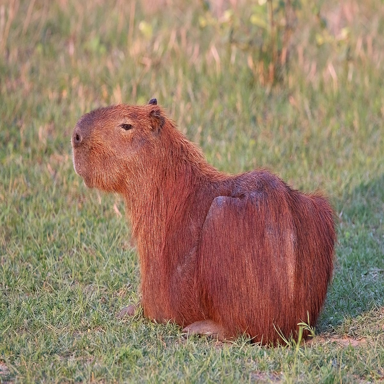

In [ ]:
top3 = outputs[0].topk(3).indices
top3 = top3.tolist()


print("Top 3 predictions:")
for class_num in top3:
    print(class_num, classes[class_num])
display(capybara_in_pil.resize((384, 384)))

Ну что ж, почти (капибар в классах ImageNet 1k, как вы могли догадаться, просто нет).

## DeiT: Data-efficient Image Transformers

Для практических задач рекомендуем использовать эту реализацию. Авторы предлагают подход, благодаря которому становится возможным обучить модель на стандартном **ImageNet** (ImageNet1k) на одной рабочей станции за 3 дня.

*We train them on a single computer in less than 3 days. Our reference vision transformer (86M parameters) achieves top-1 accuracy of 83.1% (single-crop evaluation) on ImageNet with no external data.*

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/cited_deit_vit.png"  width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2012.12877">Training data-efficient image transformers & distillation through attention</a></em></center>



Разбор этого материала уже не входит в наш курс и рекомендуется к самостоятельному изучению.

Дополнительно:

[[arxiv] 🎓Training data-efficient image transformers
& distillation through attention](https://arxiv.org/pdf/2012.12877v2.pdf)

Статьи, предшествовавшие появлению **ViT**:

[Non-local Neural Networks](https://arxiv.org/abs/1711.07971)

[CCNet: Criss-Cross Attention for Semantic Segmentation](https://arxiv.org/abs/1811.11721)






## Использование ViT с собственным датасетом

Для использования **ViT** с собственными данными рекомендуем не обучать собственную модель с нуля, а использовать уже предобученную.

Рассмотрим этот процесс на примере. Есть предобученный на **ImageNet** **Visual Transformer**, например: [deit_tiny_patch16_224](https://github.com/facebookresearch/deit)

И мы хотим использовать ее со своим датасетом, который может сильно отличаться от **ImageNet**.

Для примера возьмем **CIFAR-10**.



Загрузим модель. Как указано на [github](https://github.com/facebookresearch/deit), модель зависит от библиотеки [timm](https://fastai.github.io/timmdocs/), которую нужно установить.

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00


Теперь загружаем модель с [pytorch-hub](https://pytorch.org/hub/):

In [ ]:
import torch

model = torch.hub.load(
    "facebookresearch/deit:main", "deit_tiny_patch16_224", pretrained=True
)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Plea

Убедимся, что модель запускается.
Загрузим изображение:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/capybara.jpg

И подадим его на вход трансформеру:

torch.Size([1, 1000])


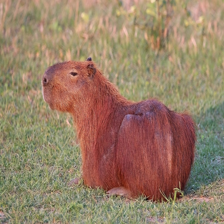

In [ ]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import torchvision.transforms as T
from PIL import Image

pil = Image.open("capybara.jpg")

# create the data transform that DeiT expects
imagenet_transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ]
)

out = model(imagenet_transform(pil).unsqueeze(0))
print(out.shape)
pil.resize((224, 224))

Чтобы использовать модель с **CIFAR-10**, нужно поменять количество выходов слоя, отвечающих за классификацию. Так как в **CIFAR-10** десять классов, а в **ImageNet** — тысяча.

Чтобы понять, как получить доступ к последнему слою, выведем структуру модели:


In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


Видим, что последний слой называется head и, судя по количеству параметров на выходе (1000), которое совпадает с количеством классов **ImageNet**, именно он отвечает за классификацию.

In [ ]:
print(model.head)

Linear(in_features=192, out_features=1000, bias=True)


Заменим его слоем с 10-ю выходами по количеству классов в CIFAR-10.

In [ ]:
model.head = torch.nn.Linear(192, 10, bias=True)

Убедимся, что модель не сломалась.

In [ ]:
out = model(imagenet_transform(pil).unsqueeze(0))
print(out.shape)

torch.Size([1, 10])


Теперь загрузим **CIFAR-10** и проверим, как дообучится модель

In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

cifar10 = CIFAR10(root="./", train=True, download=True, transform=imagenet_transform)

# We use only part of CIFAR10 to reduce training time
trainset, _ = torch.utils.data.random_split(cifar10, [10000, 40000])
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR10(root="./", train=False, download=True, transform=imagenet_transform)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 34690921.69it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


 Проведем стандартный цикл обучения.

In [ ]:
from torch import nn
from tqdm.notebook import tqdm_notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(model, train_loader, optimizer, num_epochs=1):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for batch in tqdm_notebook(train_loader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

Дообучаем (**fine tune**) только последний слой модели, который мы изменили.

In [ ]:
import torch.optim as optim

model.to(device)
optimizer = optim.SGD(model.head.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, optimizer)

  0%|          | 0/79 [00:00<?, ?it/s]

Проверим точность, на всей тестовой подвыборке **CIFAR-10**.

In [ ]:
@torch.inference_mode()
def accuracy(model, testloader):
    correct = 0
    total = 0
    for batch in testloader:
        images, labels = batch
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
    return correct / total

In [ ]:
print(f"Accuracy of fine-tuned network : {accuracy(model, test_loader):.2f} ")

Accuracy of fine-tuned network : 0.78 


Дообучив последний слой на одной эпохе с использованием 20% данных, мы получили точность ~0.75

Если дообучить все слои на 2-х эпохах, можно получить точность порядка 0.95.

Это результат намного лучше чем тот, что мы получали на семинарах.

Для этого потребуется порядка 10 мин (на GPU). Сейчас мы этого делать не будем.


И одной из причин того, что обучение идет относительно медленно, является увеличение изображений размером 32x32 до 224x224.

Если бы мы использовали изображения **CIFAR-10** в их родном размере, мы бы не потеряли никакой информации, но могли бы в разы ускорить обучение.


<font size = "6">Литература</font>

[Про трансформеры](https://arig23498.notion.site/Transformers-969f4b27c48147778c1e2dbda0c83ce0)

[Аннотированный трансформер](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

[Код множества моделей с красивыми комментариями](https://nn.labml.ai/)

[Зоопарк Трансформеров: большой обзор моделей от BERT до Alpaca](https://habr.com/ru/companies/just_ai/articles/733110/)

[Transformers in computer vision: ViT architectures, tips, tricks and improvements](https://theaisummer.com/transformers-computer-vision/)

[Illustrated transformer](https://jalammar.github.io/illustrated-transformer/)

[Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)

[Open-source реализация GPT-3](https://arankomatsuzaki.wordpress.com/2021/06/04/gpt-j/)

[Transformer для русского языка](https://github.com/vlarine/transformers-ru)

[NLP Course for you](https://lena-voita.github.io/nlp_course.html)

[Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

**Оригинальные статьи про поколения GPT:**
* [Improving Language Understanding by Generative Pre-Training (2018)](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)
* [Language Models are Unsupervised Multitask Learners (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
* [Language Models are Few-Shot Learners (2020)](https://arxiv.org/pdf/2005.14165.pdf)

**Полезные ссылки**
1. [GPT в картинках](https://habr.com/ru/post/490842/) — очень подробный разбор внутренней архитектуры GPT-2 с акцентом на иллюстрации.
2. [Трансформер в картинках](https://habr.com/ru/post/486358/) — очень подробный разбор архитектуры Transformer с акцентом на иллюстрации.
3. [Tokenizers tutorial](https://huggingface.co/docs/transformers/tokenizer_summary) — краткий разбор всех типов токенизаторов от Huggingface с примерами.
4. [Как генерировать текст](https://huggingface.co/blog/how-to-generate) — обзор способов сэмплирования текста с помощью языковых моделей (бимсёрч и тд).
5. [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) — оригинальная статья про первый трансформер.
6. [GPT-1](https://openai.com/blog/language-unsupervised/) — статья в блоге OpenAI про GPT-1.
7. [GPT-2](https://openai.com/blog/better-language-models/) — статья в блоге OpenAI про GPT-2.
8. [GPT-3](https://openai.com/blog/gpt-3-apps/) — статья в блоге OpenAI про GPT-3.
9. [WebGPT](https://openai.com/blog/improving-factual-accuracy/) — статья в блоге OpenAI про GPT-3, обученную гуглить.
10. [Codex](https://openai.com/blog/openai-codex/) — статья в блоге OpenAI про GPT-3, обученную писать код.


[Как устроен  self-attention](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html)

[Self-attention слой в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)